In [1]:

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Suppress warnings (optional)
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv("MUMBAI.csv")

INDEX : Index No. of the station

MN    : Month

HR    : Hour Code

DT    : Date

SLP   : Station Level Pressure hpa

MSLP  : Mean Sea Level Pressure hpa

DBT   : Dry bulb Temperature oC

WBT   : Wet bulb Temperature oC

DPT   : Dew point Temperature oC

RH    : Relative Humidity in %, i.e. 090 means 90 %.

VP    : Vapour Pressure in hpa

DD    : Wind Direction in 16 points of compass

FFF   : Wind Speed in Km. per hour

AW    : Average Wind speed

VV    : Visibility

Cl    : Form of Low cloud 

A     : Amount of Low cloud 

Cm    : Form of Medium cloud

A.1   : Amount of Medium cloud 

Ch    : Form of High Cloud

A.2   : Amount of High cloud

Dl    : Direction of low cloud in 8 points of compass (in code)

Dm    : Direction of medium cloud in 8 points of compass (in code)

Dh    : Direction of high cloud in 8 points of compass (in code)

TC    : Total amount of cloud (in oktas)

h     : Height of low cloud

c     : Form of individual Layer of cloud

a     : Amount of individual Layer of cloud

Ht    : Height of individual Layer of cloud (in code)

RF    : Total Rainfall since previous observation in mm

EVP   : Total Evaporation in mm

DW    : Direction of Wave in 16 points of compass (in code)

P     : Period of wave (in code)

H     : Height of wave (in code)

WAT   : Water Temperature in degree C
   

In [2]:
df=df.iloc[:,:-2]
df=df.apply(pd.to_numeric,errors='coerce')

# As avg wind speed is missing for 21126 columns 
df[['AW','FFF']].corr()
# So correlation is moderate and 75% of AW data is missing let's drop it.
df.drop(["AW"], axis=1,inplace=True)

df["HR"]=df["HR"]/4

# List of categorical columns to fill by month-wise mode
cat_cols_by_month = ['DD', 'Cm', 'A.1', 'Dl', 'Dm', 'TC', 'h', 'c', 'Ht']

# Filling each categorical column's null values using the mode of its month
for col in cat_cols_by_month:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill high-null categorical columns with month-wise mode or 'Unknown'
for col in ['Ch', 'A.2', 'Dh']:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill numeric columns with median of the respective month
for col in ['VP', 'FFF', 'VV']:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.median()))

# Fill 'DD' with mode of respective month
df['DD'] = df.groupby('MN')['DD'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill missing values with month-wise median
df['RF'] = df.groupby('MN')['RF'].transform(lambda x: x.fillna(x.median()))
# Fill by daily median first , Beacuse it may vary day to day a lot.
df['EVP'] = df.groupby(['YEAR', 'MN', 'DT'])['EVP'].transform(lambda x: x.fillna(x.median()))

# Removing INDEX and setime datetime as new Index
df=df.drop('INDEX',axis=1)
df['datetime']=pd.to_datetime(df[['YEAR','MN','DT','HR']].rename(columns={
    'YEAR':'year',
    'MN':'month',
    'DT':'day',
    'HR':'hour'
}),errors='coerce')

df.index = pd.to_datetime(df.index)
df = df[df['datetime'].dt.year != 2020]
df.set_index('datetime',inplace=True)

In [3]:
# As month,day and time don't affect fff much so drop them
df.drop(['YEAR','MN','DT','HR'],axis=1,inplace=True)

# Sorting the dataframe by timestamp
df = df.sort_values('datetime')

Outlier Detection

In [4]:
from scipy.stats import zscore
import numpy as np

# Step 1: Select numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Compute Z-scores for each numeric column
z_scores = np.abs(zscore(df[numeric_cols]))

# Step 3: Define a threshold and filter out outliers
threshold = 3
df = df[(z_scores < threshold).all(axis=1)]

In [5]:
correlation_with_fff = df.corr()['FFF'].sort_values(ascending=False)
print(correlation_with_fff)

FFF     1.000000
DD      0.805569
DBT     0.503113
WBT     0.371896
A       0.288358
Cl      0.278726
TC      0.277204
Dl      0.254787
c       0.251594
Ht      0.251594
VP      0.236208
VV      0.221812
DPT     0.216186
RF      0.208417
Dm      0.188280
Cm      0.178491
A.1     0.149542
A.2     0.001219
Ch     -0.001513
Dh     -0.004911
RH     -0.233898
EVP    -0.237352
h      -0.265520
a      -0.266727
SLP    -0.364263
MSLP   -0.366972
Name: FFF, dtype: float64


In [6]:
import numpy as np
df['VP_log'] = np.log1p(df['VP'])      
df['RF_sqrt'] = np.sqrt(df['RF'])       # for skewed rainfall

df['temp_diff'] = df['DBT'] - df['WBT']     # humidity proxy
df['humid_ratio'] = df['VP'] / (df['DBT'] + 0.1)
df['wind_humidity'] = df['RH'] * df['VV']

df['VV_squared'] = df['VV'] ** 2
df['DPT_squared'] = df['DPT'] ** 2

df['VP_roll3'] = df['VP'].rolling(window=3).mean()
df['RF_lag1'] = df['RF'].shift(1)

from scipy.stats.mstats import winsorize

df['RF_winz'] = winsorize(df['RF'], limits=[0.01, 0.01])

df['month'] = df.index.month
df['season'] = df['month'] % 12 // 3 + 1  # Season: 1=spring, ..., 4=winter

# Cyclic encode ==>> As months are in a cycle 1->12->1
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# (Optional) Drop original month column
df.drop('month', axis=1, inplace=True)

# One hot encoding ==>> COnverting categorical into Binary data
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)
df.drop('season', axis=1, inplace=True)

df.dropna(axis=0,inplace=True)
df.isnull().sum()
df.dtypes

SLP              float64
MSLP             float64
DBT              float64
WBT              float64
DPT              float64
RH                 int64
VP               float64
DD               float64
FFF              float64
VV               float64
Cl                 int64
A                  int64
Cm               float64
A.1              float64
Ch               float64
A.2              float64
Dl               float64
Dm               float64
Dh               float64
TC               float64
h                float64
c                float64
a                  int64
Ht               float64
RF               float64
EVP              float64
VP_log           float64
RF_sqrt          float64
temp_diff        float64
humid_ratio      float64
wind_humidity    float64
VV_squared       float64
DPT_squared      float64
VP_roll3         float64
RF_lag1          float64
RF_winz          float64
month_sin        float64
month_cos        float64
season_1            bool
season_2            bool


In [7]:
correlation_with_fff = df.corr()['FFF'].sort_values(ascending=False)
print(correlation_with_fff)

FFF              1.000000
DD               0.805563
DBT              0.503082
WBT              0.371856
season_3         0.318829
A                0.288327
Cl               0.278701
TC               0.277176
temp_diff        0.268573
Dl               0.254756
Ht               0.251561
c                0.251561
VP               0.236170
DPT_squared      0.235686
VP_roll3         0.235277
RF_sqrt          0.224903
VV_squared       0.221806
VV               0.221806
DPT              0.216145
RF_lag1          0.214820
VP_log           0.214292
RF_winz          0.211845
RF               0.208381
Dm               0.188260
Cm               0.178474
A.1              0.149546
season_2         0.034374
A.2              0.001219
Ch              -0.001514
Dh              -0.004912
month_sin       -0.047058
humid_ratio     -0.065695
season_1        -0.178314
season_4        -0.193495
wind_humidity   -0.232113
RH              -0.233935
EVP             -0.237316
h               -0.265488
a           

In [8]:
# Feature columns (you can fine-tune this list)
features = [
     'DD', 'DBT', 'WBT', 'A', 'temp_diff', 'Cl', 'TC', 'Dl', 'c', 'Ht',
    'DPT_squared', 'VP', 'VP_roll3', 'RF_sqrt', 'VV_squared', 'VV',
    'RF_lag1', 'DPT', 'VP_log', 'RF_winz', 'RF', 'Dm', 'Cm', 'A.1','season_1','season_2','season_3','season_4','month_sin','month_cos'
]
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# X = your features, y = your target (e.g. FFF)
X = df[features]  # your selected columns
Y = df['FFF']

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

DD             0.772277
VP_roll3       0.045990
temp_diff      0.026797
DBT            0.025460
WBT            0.013895
season_3       0.012982
VP_log         0.008638
VP             0.008501
RF_lag1        0.008400
month_cos      0.008382
DPT_squared    0.008250
TC             0.008248
DPT            0.007986
month_sin      0.007818
A              0.005571
Cl             0.004424
A.1            0.004071
season_2       0.003314
VV             0.002629
VV_squared     0.002608
RF             0.002600
RF_sqrt        0.002541
RF_winz        0.002368
Cm             0.002046
Ht             0.001233
c              0.001162
Dm             0.000799
season_4       0.000470
season_1       0.000295
Dl             0.000242
dtype: float64


In [9]:
# SO NOW WILL SPLIT FEATURES INTO 3 GROUPS
primary_features=['DD', 'DBT', 'WBT', 'DPT', 'DPT_squared', 'VP_log', 'VP_roll3', 'RF_lag1',
 'VP', 'temp_diff', 'TC', 'A', 'Cl','season_3','month_sin','month_cos']
# Will try with these also and check is model performing more better or not.
secondary_features=['Dl','Ht', 'c', 'VV', 'Dm', 'Cm','season_2']

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Choose features and target

data = df[primary_features].copy()
target = df[['FFF']]

# Step 2: Scale the features
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(data)
y_scaled = scaler_y.fit_transform(target)

# Step 3: Define window size (e.g., 8 time steps = past 24 hours)
window_size = 8  # 3-hourly × 8 = 24 hours

# Step 4: Create sequences
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

print("Input shape:", X_seq.shape)
print("Target shape:", y_seq.shape)


Input shape: (22548, 8, 16)
Target shape: (22548, 1)


In [11]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Step 1: Flatten y_seq (it was 2D because of MinMaxScaler)
y_seq = y_seq.reshape(-1, 1)

# Step 2: Train-Test Split (e.g., 80-20)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False )

# Step 3: Convert to TensorFlow Datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Train samples: 18038
Test samples: 4510


In [12]:
from tensorflow.keras import layers, models

# Step 1: Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self._get_positional_encoding(sequence_len, d_model)

    def _get_positional_encoding(self, seq_len, d_model):
        angle_rads = np.arange(seq_len)[:, np.newaxis] / np.power(
            10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]



In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward network
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    x = layers.Dropout(dropout)(ffn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)

    return x

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    # Linear projection to d_model dimension
    x = layers.Dense(head_size)(inputs)

    # Add positional encoding
    x = PositionalEncoding(input_shape[0], head_size)(x)

    # Transformer Encoder block(s)
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global average pooling over time dimension
    x = layers.GlobalAveragePooling1D()(x)

    # Final Dense layers
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1)(x)  # regression output

    model = models.Model(inputs, outputs)
    return model


In [14]:
import random

# Search space boundaries for GA
search_space = {
    'head_size': [32, 64, 128],
    'num_heads': [2, 4, 8],
    'ff_dim': [64, 128, 256],
    'dropout': [0.0, 0.1, 0.2],
    'learning_rate': [1e-3, 1e-4, 5e-5],
    'batch_size': [16, 32, 64]
}

# Objective function for GA: returns MSE on validation set
def evaluate_individual(params):
    head_size, num_heads, ff_dim, dropout, learning_rate, batch_size = params

    try:
        # Re-create dataset with this batch size
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Build and compile model
        model = build_transformer_model(X_train.shape[1:], head_size, num_heads, ff_dim, dropout)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                      loss='mse', metrics=['mae'])

        # Train briefly (few epochs to keep fast)
        model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=0)

        # Predict and calculate MSE
        y_pred = model.predict(X_test, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred)
        y_true = scaler_y.inverse_transform(y_test)

        mse = mean_squared_error(y_true, y_pred)
        return mse
    except Exception as e:
        print(f"Error in evaluation: {e}")
        return float('inf')  # Penalize invalid runs


In [15]:
# Genetic Algorithm Loop

# Generate a random individual (one solution)
def generate_individual():
    return [
        random.choice(search_space['head_size']),
        random.choice(search_space['num_heads']),
        random.choice(search_space['ff_dim']),
        random.choice(search_space['dropout']),
        random.choice(search_space['learning_rate']),
        random.choice(search_space['batch_size']),
    ]

# Crossover: single point crossover
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Mutation: randomly change one gene
def mutate(individual, mutation_rate=0.3):
    if random.random() < mutation_rate:
        idx = random.randint(0, len(individual) - 1)
        keys = list(search_space.keys())
        individual[idx] = random.choice(search_space[keys[idx]])
    return individual

# GA Parameters
population_size = 6
generations = 5
top_k = 2  # survivors per generation

# Initialize population
population = [generate_individual() for _ in range(population_size)]

# Track best
best_mse = float('inf')
best_params = None

# GA Loop
for gen in range(generations):
    print(f"\n Generation {gen + 1}/{generations}")

    # Evaluate population
    scored_population = []
    for individual in population:
        mse = evaluate_individual(individual)
        scored_population.append((mse, individual))
        print(f"Params: {individual}, MSE: {mse:.4f}")

    # Sort by performance (lower MSE is better)
    scored_population.sort(key=lambda x: x[0])
    population = [ind for _, ind in scored_population[:top_k]]

    # Save best overall
    if scored_population[0][0] < best_mse:
        best_mse = scored_population[0][0]
        best_params = scored_population[0][1]

    # Reproduce new generation
    new_population = population.copy()
    while len(new_population) < population_size:
        parent1, parent2 = random.sample(population, 2)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])

    population = new_population[:population_size]  # ensure fixed size

print("\n Best Parameters Found:")
print("Params:", best_params)
print("Best MSE:", best_mse)



 Generation 1/5
Params: [64, 8, 256, 0.2, 5e-05, 16], MSE: 24.0808
Params: [32, 2, 64, 0.1, 0.001, 64], MSE: 25.1563
Params: [32, 8, 128, 0.1, 5e-05, 16], MSE: 25.7556
Params: [128, 4, 64, 0.1, 5e-05, 32], MSE: 36.7285
Params: [32, 8, 256, 0.1, 5e-05, 32], MSE: 23.3100
Params: [32, 2, 256, 0.2, 0.0001, 32], MSE: 25.1567

 Generation 2/5
Params: [32, 8, 256, 0.1, 5e-05, 32], MSE: 26.6720
Params: [64, 8, 256, 0.2, 5e-05, 16], MSE: 23.0891
Params: [32, 8, 256, 0.2, 5e-05, 16], MSE: 24.4960
Params: [64, 8, 256, 0.1, 5e-05, 32], MSE: 24.1492
Params: [32, 8, 256, 0.1, 5e-05, 16], MSE: 25.4476
Params: [64, 8, 256, 0.2, 5e-05, 32], MSE: 27.4910

 Generation 3/5
Params: [64, 8, 256, 0.2, 5e-05, 16], MSE: 23.7415
Params: [64, 8, 256, 0.1, 5e-05, 32], MSE: 25.6301
Params: [64, 8, 256, 0.2, 5e-05, 16], MSE: 23.3758
Params: [64, 8, 256, 0.1, 5e-05, 32], MSE: 26.2797
Params: [64, 8, 256, 0.1, 5e-05, 16], MSE: 22.0413
Params: [64, 8, 256, 0.2, 5e-05, 32], MSE: 22.8855

 Generation 4/5
Params: [64, 8

In [16]:
# Final Training using Best GA Hyperparameters

# Unpack best hyperparameters
head_size, num_heads, ff_dim, dropout, learning_rate, batch_size = best_params

# Prepare datasets again with best batch size
final_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
final_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build and compile model
final_model = build_transformer_model(
    input_shape=X_train.shape[1:],
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout
)

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='mse',
    metrics=['mae']
)

# Train with early stopping
final_model.fit(
    final_train_dataset,
    validation_data=final_test_dataset,
    epochs=100,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.1877 - mae: 0.2975 - val_loss: 0.0813 - val_mae: 0.2294
Epoch 2/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0502 - mae: 0.1866 - val_loss: 0.0656 - val_mae: 0.2019
Epoch 3/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0448 - mae: 0.1722 - val_loss: 0.0544 - val_mae: 0.1842
Epoch 4/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0404 - mae: 0.1620 - val_loss: 0.0436 - val_mae: 0.1577
Epoch 5/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0377 - mae: 0.1547 - val_loss: 0.0413 - val_mae: 0.1522
Epoch 6/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0364 - mae: 0.1513 - val_loss: 0.0413 - val_mae: 0.1487
Epoch 7/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0358 - mae: 0.1502 - val_loss: 0.0394 - val_mae: 0.1465
Epoch 8/100
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0351 - mae: 0.1485 - val_loss: 0.0396 - val_mae: 0.1467
Epoch 9/100
1128

Final Evaluation on Test Set:
MAE: 3.44
MSE: 21.89
R² Score: 0.4135


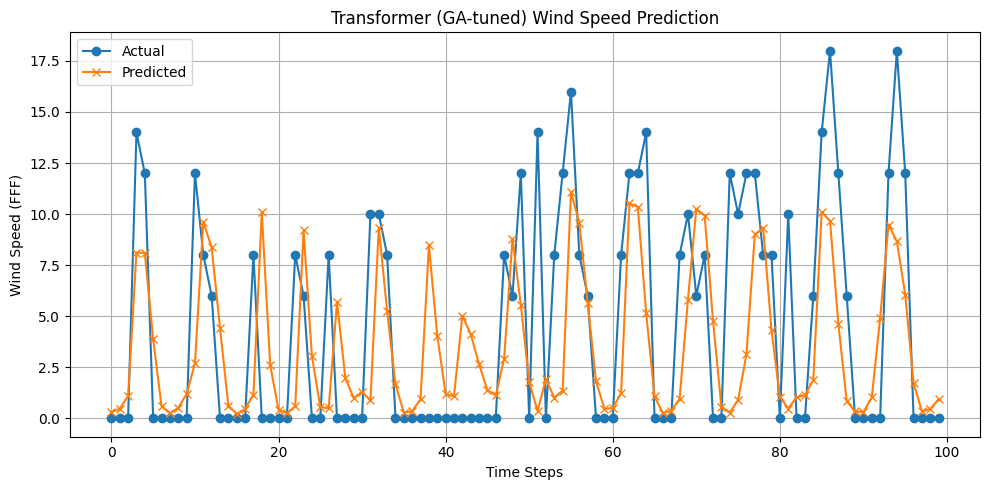

In [17]:
# Predict using final best model
y_final_pred_scaled = final_model.predict(X_test, verbose=0)

# Inverse transform to get actual wind speed
y_final_pred = scaler_y.inverse_transform(y_final_pred_scaled)
y_final_true = scaler_y.inverse_transform(y_test)

# Metrics
final_mae = mean_absolute_error(y_final_true, y_final_pred)
final_mse = mean_squared_error(y_final_true, y_final_pred)
final_r2 = r2_score(y_final_true, y_final_pred)

print("Final Evaluation on Test Set:")
print(f"MAE: {final_mae:.2f}")
print(f"MSE: {final_mse:.2f}")
print(f"R² Score: {final_r2:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_final_true[:100], label="Actual", marker='o')
plt.plot(y_final_pred[:100], label="Predicted", marker='x')
plt.title("Transformer (GA-tuned) Wind Speed Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Wind Speed (FFF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Directory for saving plots and CSV
output_dir = "plot"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

import pandas as pd

# Replace with actual best values from your GWO
result = {
   "head_size":head_size,
   "num_heads":num_heads,
   "ff_dim":ff_dim,
   "dropout":dropout,
   "learning_rate":learning_rate,
   "batch_size":batch_size,
   "mse":final_mse,
   "mae":final_mae,
   "R2":final_r2
}

csv_path = os.path.join(output_dir, "history_Tr.csv")

# Append to CSV
if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path)
    df_existing = pd.concat([df_existing, pd.DataFrame([result])], ignore_index=True)
    df_existing.to_csv(csv_path, index=False)
else:
    pd.DataFrame([result]).to_csv(csv_path, index=False)

print(f"Results appended to CSV: {csv_path}")


Results appended to CSV: plot/history_Tr.csv
